# Import Libraries

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import sqlite3


# Connect to data
# set up dataFrame and run first query

In [3]:
df = pd.read_csv('/mnt/c/Projects/Mock_Stripe_Subscriptions.csv')
# Create a SQLite DB in memory or file
conn = sqlite3.connect('/mnt/c/Projects/Mock_Stripe_Subscriptions.db')  # Or ":memory:" for temporary

# Save the DataFrame as a table
df.to_sql("subscriptions", conn, if_exists="replace", index=False)

query = """
SELECT price_point, COUNT(*) as total
FROM subscriptions
WHERE status != 'churned'
GROUP BY price_point
"""
result_df = pd.read_sql_query(query, conn)

print(result_df.head())



  price_point  total
0       Basic     54
1     Premium     50
2    Standard     26


# Check for null values

In [4]:
df.isnull().sum()

subscription_id    0
month              0
event_type         0
status             0
price_point        0
dtype: int64

# Check for duplicates and remove them

In [5]:
df.duplicated().sum()  # Count duplicate rows
df.drop_duplicates(inplace=True)


# Check the different price_point types and counts on them

In [6]:
df['event_type'].value_counts()
df['status'].value_counts()
df['price_point'].value_counts()


price_point
Premium     75
Basic       70
Standard    34
Name: count, dtype: int64

# Convert months to datetime

In [7]:
df['month'] = pd.to_datetime(df['month'])


# Sort by subscription_Id, month

In [8]:
df.sort_values(by=['subscription_id', 'month'], inplace=True)


# Query price_point by month

In [9]:
query = """
SELECT price_point, month from subscriptions group by month
"""
result_df = pd.read_sql_query(query, conn)

print(result_df.head())

conn.close()

  price_point       month
0       Basic  2024-01-01
1     Premium  2024-02-01
2     Premium  2024-03-01
3       Basic  2024-04-01
4       Basic  2024-05-01


# Set up data visualization for month, price_points over 6 months

In [10]:
monthly_counts = df.groupby(['month', 'price_point']).size().reset_index(name='subscriber_count')


In [11]:
pivot = monthly_counts.pivot(index='month', columns='price_point', values='subscriber_count').fillna(0).astype(int)


In [12]:
pivot['Total'] = pivot.sum(axis=1)


# Create line plot of price_points by month

<Axes: xlabel='month'>

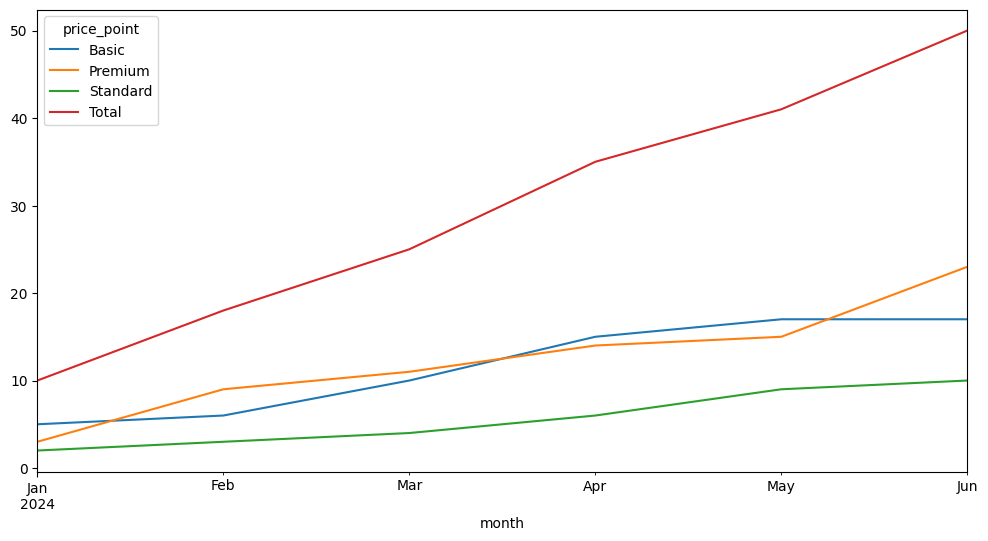

In [13]:
pivot.plot(kind='line',figsize=(12, 6))

## Insights: New Subscriptions Over Time (Line Plot)
Overall growth is steady across all price points, with notable gains after March.

Basic Plan subscriptions increased modestly by ~3% from January to June, showing consistent retention.

Premium Plan saw the largest jump, growing from 3% to 21% — an 18% increase, suggesting a surge in perceived value or successful upselling.

Standard Plan rose by ~5%, but showed signs of volatility in April, where churn rates also spiked.

# Calculate churn by price_point

In [14]:
churned = df[df['event_type'] == 'churned']
churn_counts = churned.groupby('month').size()


In [15]:
new_counts = df[df['event_type'] == 'new'].groupby('month').size()
net_gain = new_counts.sub(churn_counts, fill_value=0)


# Calculate switches

In [16]:
switched = df[df['event_type'] == 'switched']
switched.groupby(['month', 'price_point']).size()


month       price_point
2024-01-01  Basic          1
2024-02-01  Premium        1
2024-03-01  Basic          1
2024-04-01  Basic          1
            Premium        3
            Standard       1
2024-05-01  Basic          1
            Standard       2
2024-06-01  Basic          1
            Premium        3
            Standard       3
dtype: int64

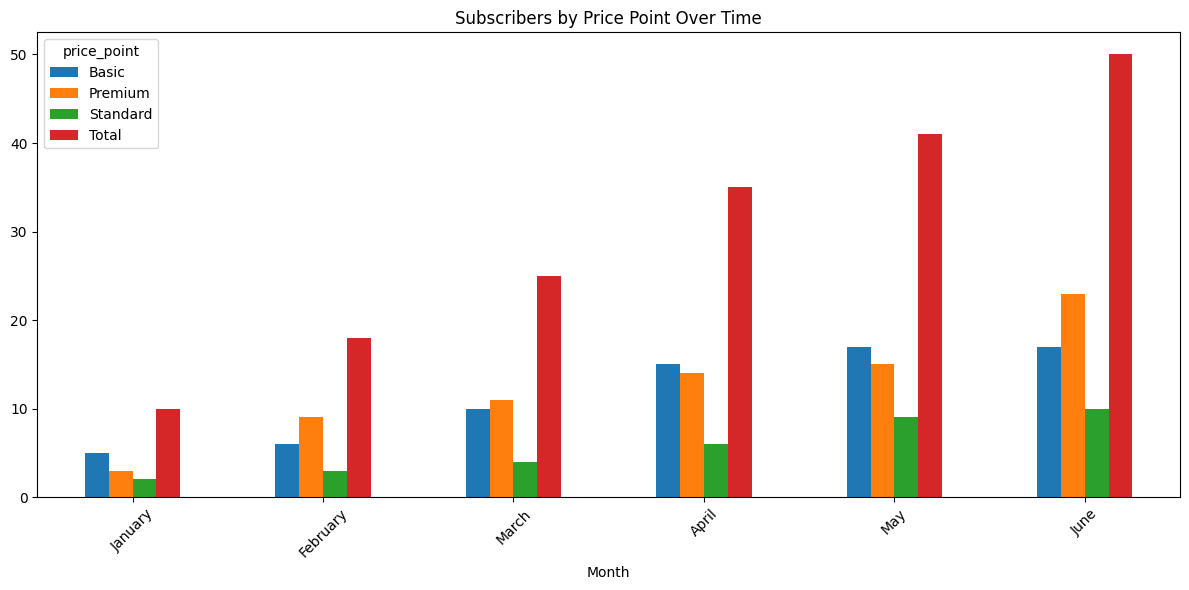

In [38]:
import calendar

# Plot with month names instead of full datetime

# Create a mapping from datetime to month name
month_names = pivot.index.to_series().dt.strftime('%B')

# Plot with month names as x-axis labels
ax = pivot.plot(kind='bar', figsize=(12, 6))
#ax.set_xticks(range(len(month_names)))
ax.set_xticklabels(month_names, rotation=45)
ax.set_xlabel('Month')
ax.set_title('Subscribers by Price Point Over Time')
plt.tight_layout()
plt.show()

##  Insights: Subscribers by Price Point Over Time
Total subscriptions exhibit consistent monthly growth from January through June.

Premium is the top-performing tier, showing steady and significant growth, making it the strongest contributor overall.

Basic is the second-best performer, maintaining consistent upward movement with no signs of churn dominance.

Standard shows growth but at a slower, more stable pace than the other two tiers. It lacks the momentum of Premium or Basic.

Overall, the growth pattern aligns with strategic goals, as both Standard and Premium were targeted for expansion, and both are contributing positively—particularly Premium.

In [26]:
# Sort data by price_point and swtich_in or swtich_out

In [19]:
# Ensure data is sorted by subscription_id and month
df_sorted = df.sort_values(['subscription_id', 'month'])

# Get previous price_point for each subscription
df_sorted['prev_price_point'] = df_sorted.groupby('subscription_id')['price_point'].shift(1)

# Identify switches (where price_point changed and event_type is 'switched')
switch_mask = (df_sorted['price_point'] != df_sorted['prev_price_point']) & df_sorted['prev_price_point'].notnull()

# Switch-ins: count where they switched TO each price_point
switch_ins = df_sorted[switch_mask].groupby('price_point').size()

# Switch-outs: count where they switched FROM each price_point
switch_outs = df_sorted[switch_mask].groupby('prev_price_point').size()

print("Switch-ins:\n", switch_ins)
print("\nSwitch-outs:\n", switch_outs)

Switch-ins:
 price_point
Basic       3
Premium     5
Standard    5
dtype: int64

Switch-outs:
 prev_price_point
Basic       6
Premium     2
Standard    5
dtype: int64


#Visualize switches

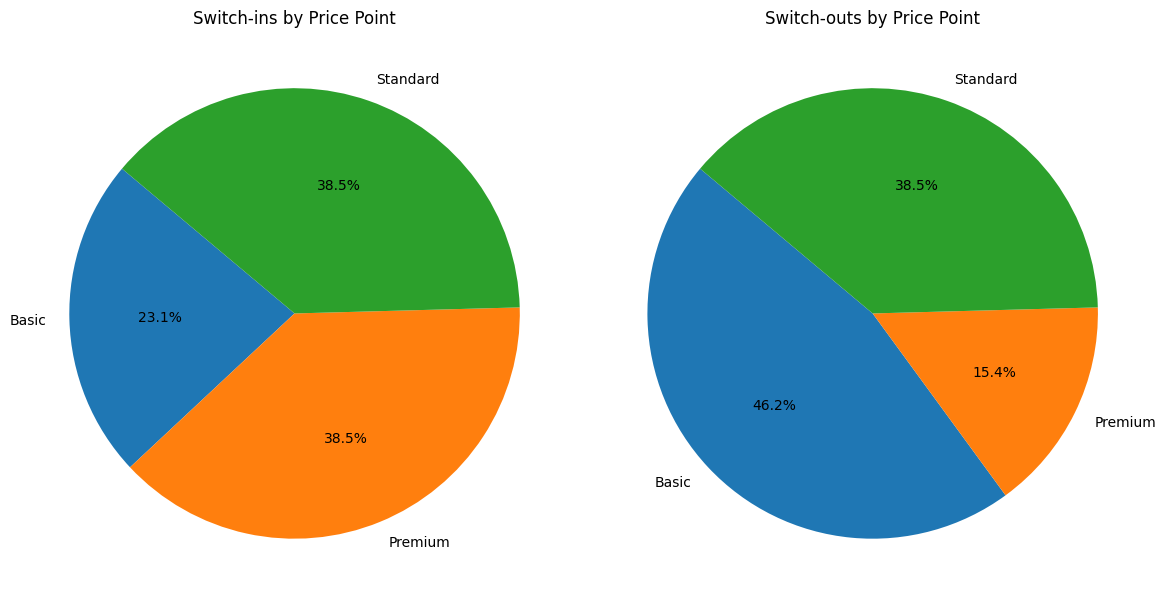

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart for switch-ins
axs[0].pie(switch_ins, labels=switch_ins.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Switch-ins by Price Point')

# Pie chart for switch-outs
axs[1].pie(switch_outs, labels=switch_outs.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Switch-outs by Price Point')

plt.tight_layout()
plt.show()


##  Insights: Switch_ins and Switch_outs by Price Point
Standard remained static, showing neither notable upgrades nor downgrades—indicating a disengaged or less dynamic user segment.

Premium showed positive retention, with 38.5% switch_ins and only 15.4% switch_outs, suggesting it's becoming the preferred upgrade destination.

Basic experienced the most churn, shifting from 23.1% switch_ins to 46.2% switch_outs, indicating that many users may be upgrading to Premium.

Interpretation: This pattern supports a successful value proposition for Premium, as users appear willing to leave Basic for enhanced features or services. 

# Switch Rates  by month

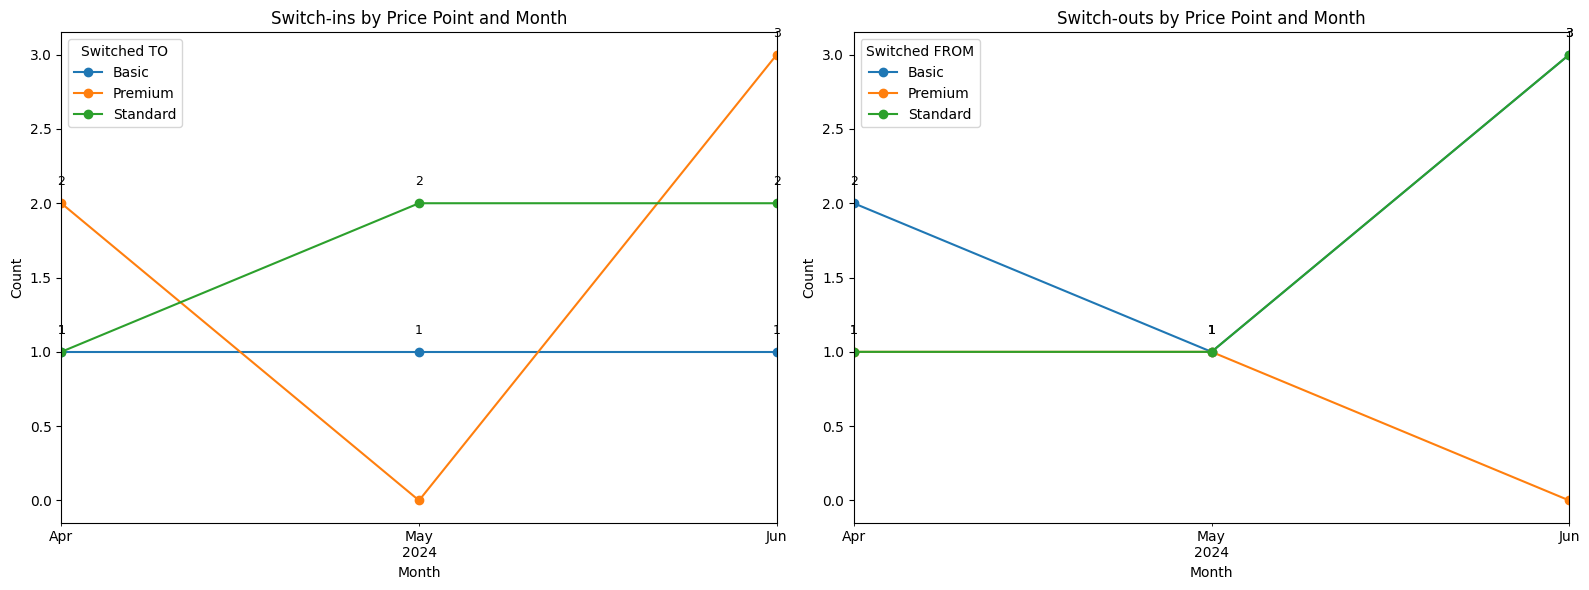

In [39]:
# Plot switch-ins and switch-outs by month
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# --- Switch-ins ---
switch_ins_monthly.plot(ax=axs[0], marker='o')
axs[0].set_title('Switch-ins by Price Point and Month')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Month')
axs[0].legend(title='Switched TO')

# Add annotations for switch-ins
for price_point in switch_ins_monthly.columns:
    for i, value in enumerate(switch_ins_monthly[price_point]):
        if value > 0:
            axs[0].text(switch_ins_monthly.index[i], value + 0.1, str(value),
                        fontsize=9, ha='center', va='bottom')

# --- Switch-outs ---
switch_outs_monthly.plot(ax=axs[1], marker='o')
axs[1].set_title('Switch-outs by Price Point and Month')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Month')
axs[1].legend(title='Switched FROM')

# Add annotations for switch-outs
for price_point in switch_outs_monthly.columns:
    for i, value in enumerate(switch_outs_monthly[price_point]):
        if value > 0:
            axs[1].text(switch_outs_monthly.index[i], value + 0.1, str(value),
                        fontsize=9, ha='center', va='bottom')

plt.tight_layout()
plt.show()


## The Swich_ins and Switch_Outs by price_point and Month
 Insights: Subscriber Movement (Switch-ins and Switch-outs)
Standard remained static in switch-ins and showed a spike in switch-outs in June—potential red flag for retention.

Premium rebounded in June with the highest switch-in count and no switch-outs, suggesting strong retention and late-quarter momentum.

Basic started with the highest switch-outs and minimal switch-ins, but by June had stabilized—indicating some churn resolved, possibly by migration to Premium.

Overall, the subscriber migration flow favors Premium, suggesting users are willing to pay more for perceived value.


## Calculate Key Metrics
We define basic KPIs to understand subscriber behavior:
- **Churn Rate** = Churned / (Active + Churned)
- **Pause Rate** = Paused / Total
- **New Subscriptions per Month** = Count of `event_type == "new"`

Below are the calculations:

In [21]:
# Calculate churned, active, paused, and total subscribers
churned_count = df[df['event_type'] == 'churned'].shape[0]
active_count = df[df['status'] == 'active'].shape[0]
paused_count = df[df['status'] == 'paused'].shape[0]
total_count = df.shape[0]

# Churn Rate
churn_rate = churned_count / (active_count + churned_count)

# Pause Rate
pause_rate = paused_count / total_count

# New Subscriptions per Month
new_subs_per_month = df[df['event_type'] == 'new'].groupby('month').size()

print(f"Churn Rate: {churn_rate:.2%}")
print(f"Pause Rate: {pause_rate:.2%}")
print("New Subscriptions per Month:")
print(new_subs_per_month)

Churn Rate: 29.25%
Pause Rate: 30.73%
New Subscriptions per Month:
month
2024-01-01     5
2024-02-01     7
2024-03-01    12
2024-04-01    17
2024-05-01    15
2024-06-01    19
dtype: int64


## Visualization of Rates of Churn, Pause,  and New Subscriptions per Month

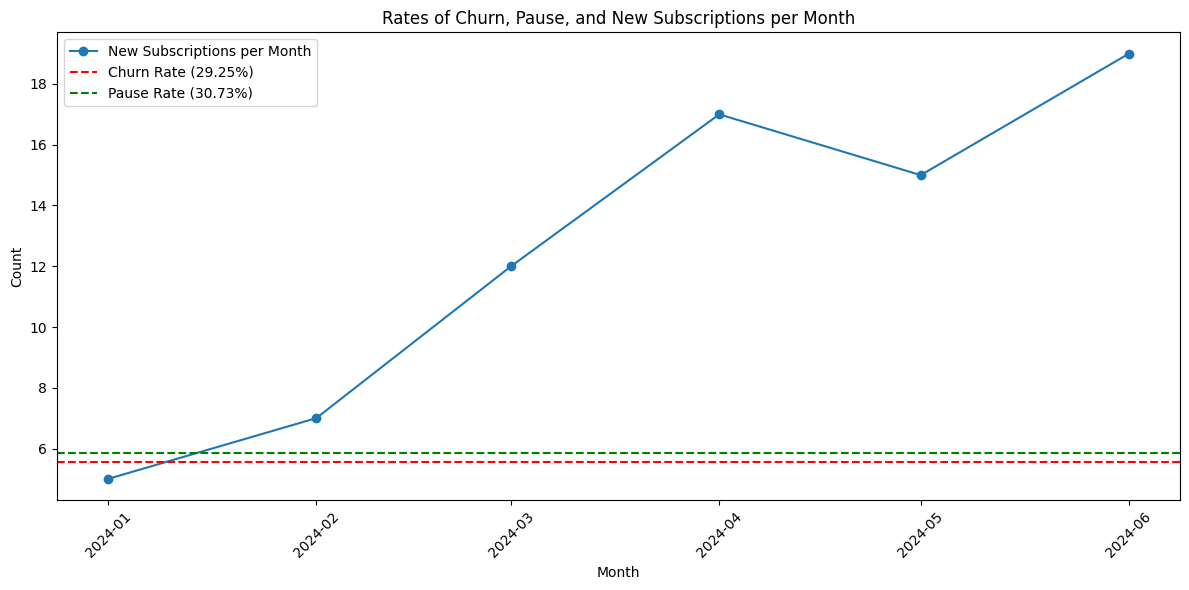

In [23]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot new subscriptions per month
ax1.plot(new_subs_per_month.index, new_subs_per_month.values, marker='o', label='New Subscriptions per Month')

# Plot churn and pause rates as horizontal lines
ax1.axhline(y=churn_rate * max(new_subs_per_month.values), color='r', linestyle='--', label=f'Churn Rate ({churn_rate:.2%})')
ax1.axhline(y=pause_rate * max(new_subs_per_month.values), color='g', linestyle='--', label=f'Pause Rate ({pause_rate:.2%})')

ax1.set_title("Rates of Churn, Pause, and New Subscriptions per Month")
ax1.set_xlabel("Month")
ax1.set_ylabel("Count")
ax1.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Rates of Churn, Pause, and New Subscriptions
Both Churn and Pause remain steady at 29.25% and 30.73% respectively. Conversely, New Subscriptions per Month increase every month with the exception of April. See final Summary for analysis.

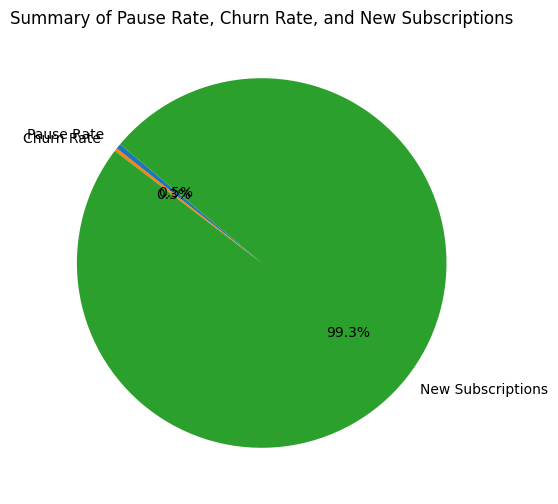

In [30]:
# For a summary pie chart, use the overall rates (not by price_point) and the total new subscriptions

# Use the mean of pause_rate and churn_rate Series for overall rates
overall_pause_rate = pause_rate.mean()
overall_churn_rate = churn_rate.mean()
total_new_subs = new_subs_per_month.sum()

values = [overall_pause_rate, overall_churn_rate, total_new_subs]
labels = ['Pause Rate', 'Churn Rate', 'New Subscriptions']

plt.figure(figsize=(6, 6))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Summary of Pause Rate, Churn Rate, and New Subscriptions')
plt.show()

## Churn Rate by price_point

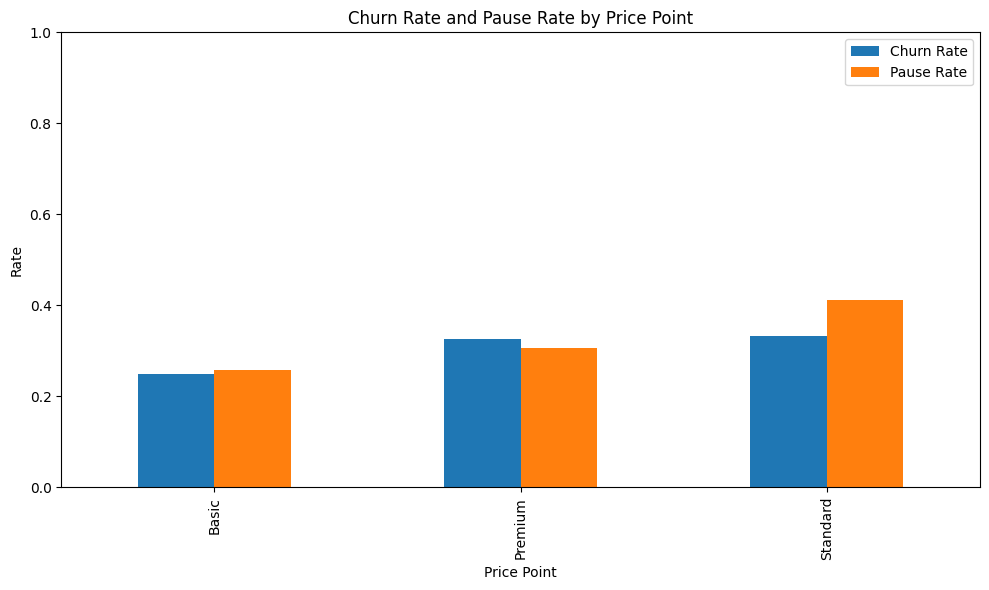

In [24]:
# Calculate churn rate and pause rate by price_point
churn_by_price = df[df['event_type'] == 'churned'].groupby('price_point').size()
pause_by_price = df[df['status'] == 'paused'].groupby('price_point').size()
total_by_price = df.groupby('price_point').size()

churn_rate_by_price = (churn_by_price / (df[df['status'] == 'active'].groupby('price_point').size().add(churn_by_price, fill_value=0))).fillna(0)
pause_rate_by_price = (pause_by_price / total_by_price).fillna(0)

# Combine into a DataFrame for plotting
kpi_by_price = pd.DataFrame({
    'Churn Rate': churn_rate_by_price,
    'Pause Rate': pause_rate_by_price
})

kpi_by_price.plot(kind='bar', figsize=(10, 6))
plt.title('Churn Rate and Pause Rate by Price Point')
plt.ylabel('Rate')
plt.xlabel('Price Point')
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Calculate churn rate and pause rate by price_point for each month

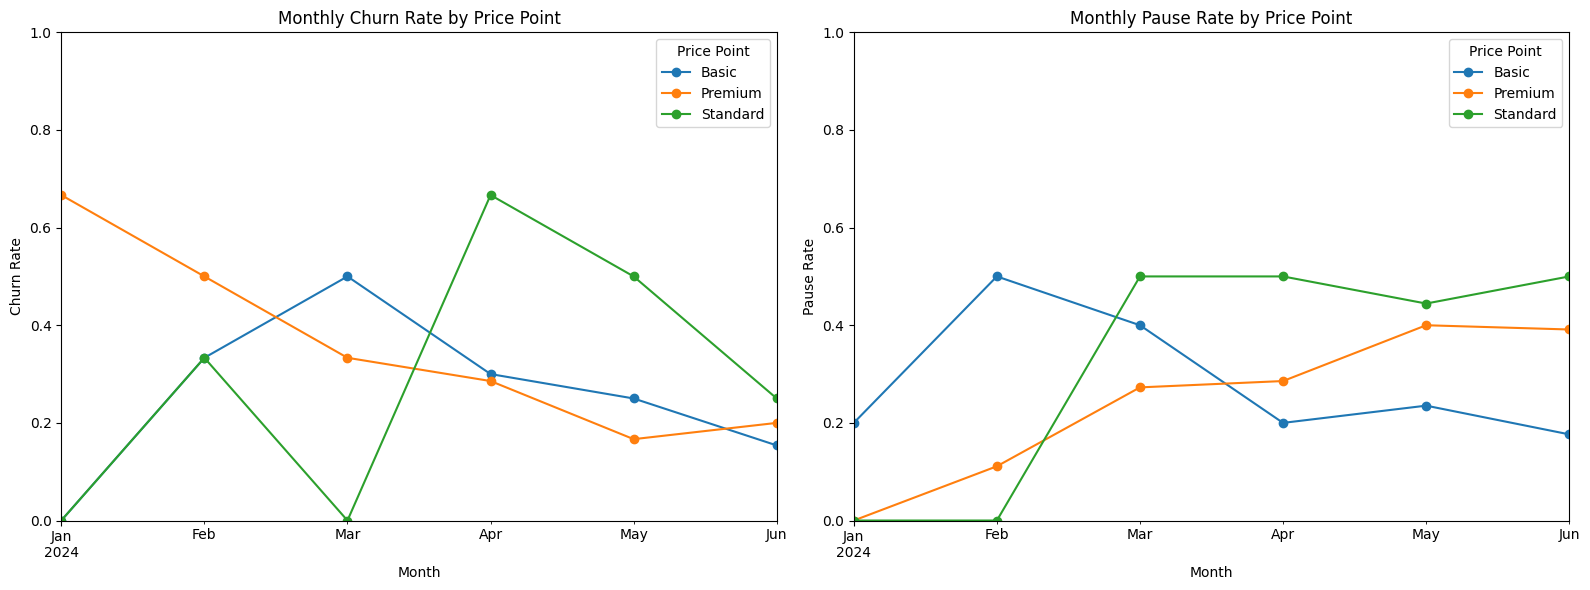

In [ ]:

monthly_kpi = []

for month, group in df.groupby('month'):
    churned = group[group['event_type'] == 'churned'].groupby('price_point').size()
    paused = group[group['status'] == 'paused'].groupby('price_point').size()
    active = group[group['status'] == 'active'].groupby('price_point').size()
    total = group.groupby('price_point').size()
    churn_rate = (churned / (active.add(churned, fill_value=0))).fillna(0)
    pause_rate = (paused / total).fillna(0)
    for price_point in total.index:
        monthly_kpi.append({
            'month': month,
            'price_point': price_point,
            'Churn Rate': churn_rate.get(price_point, 0),
            'Pause Rate': pause_rate.get(price_point, 0)
        })

monthly_kpi_df = pd.DataFrame(monthly_kpi)

# Pivot for plotting
pivot_churn = monthly_kpi_df.pivot(index='month', columns='price_point', values='Churn Rate')
pivot_pause = monthly_kpi_df.pivot(index='month', columns='price_point', values='Pause Rate')

fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

pivot_churn.plot(ax=axs[0], marker='o')
axs[0].set_title('Monthly Churn Rate by Price Point')
axs[0].set_ylabel('Churn Rate')
axs[0].set_xlabel('Month')
axs[0].set_ylim(0, 1)
axs[0].legend(title='Price Point')

pivot_pause.plot(ax=axs[1], marker='o')
axs[1].set_title('Monthly Pause Rate by Price Point')
axs[1].set_ylabel('Pause Rate')
axs[1].set_xlabel('Month')
axs[1].set_ylim(0, 1)
axs[1].legend(title='Price Point')

plt.tight_layout()
plt.show()

## Monthly Churn Rate and Pause Rate by Price Point 
Insights: Churn and Pause Rate Trends by Price Point
Churn rate saw a 4% decrease overall, while pause rate increased by 4% during the same period—potentially signaling a behavioral tradeoff: users may be pausing instead of canceling.

Basic plan showed stability:

Churn peaked at ~5% and steadily dropped below 2%

Pause rate peaked first, then declined—suggesting pause may have prevented churn

This indicates strong perceived value and recovery over time.

Standard plan was the most volatile:

Churn peaked twice (3% early on, then 7% later)

Pause rate hovered around 5% and plateaued, indicating possible dissatisfaction or indecision

Standard is likely underperforming in value delivery.

Premium plan showed the lowest and most stable churn/pause behavior, reinforcing its position as the most desirable tier.

Conclusion:

Basic and Premium plans appear well-positioned, with subscribers finding long-term satisfaction.

Standard plan may need a redesign or improved communication of its value to prevent churn and reliance on pause behavior.

## Final Summary
- **April was a tipping point**: churn spiked, new subscriptions dropped.
- **Standard plan** is struggling with retention.
- **Basic plan** remains stable with lowest churn/pause.
- Recommend investigating pricing, feature value, and marketing for Standard.